# Prediccion de winner


In [ ]:
import pandas as pd
from google.colab import files
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # Programación vectorial

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Raúl
url='/content/drive/MyDrive/Machine Learning/Prueba 2/Anexo ET_demo_round_traces_2022.csv'
df = pd.read_csv(url, sep=";", encoding='utf-8')


/tmp/ipython-input-184-74522312.py:3: DtypeWarning: Columns (6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(url, sep=";", encoding='utf-8')


In [ ]:
#Sofia
url = '/content/drive/MyDrive/Fundamentos de machine learning/Anexo ET_demo_round_traces_2022.csv'
df = pd.read_csv(url, sep=";", encoding='utf-8')


In [ ]:
#Con esta linea de codigo podemos asegurarnos de que las variables a utilizar sean numericas
df['MatchAssists'] = pd.to_numeric(df['MatchAssists'], errors='coerce')
df['TimeAlive'] = pd.to_numeric(df['TimeAlive'], errors='coerce')
df['MatchHeadshots'] = pd.to_numeric(df['MatchHeadshots'], errors='coerce')
df['RoundKills'] = pd.to_numeric(df['RoundKills'], errors='coerce')
df['PrimarySniperRifle'] = df['PrimarySniperRifle'].round().astype(int)
df['PrimaryAssaultRifle'] = df['PrimaryAssaultRifle'].round().astype(int)
df['PrimaryHeavy'] = df['PrimaryHeavy'].round().astype(int)
df['PrimarySMG'] = df['PrimarySMG'].round().astype(int)

In [ ]:
# 3.1. Imputar NaN en columnas numéricas usando la media
num_cols = df.select_dtypes(include=[np.number]).columns

for col in num_cols:
    if df[col].isnull().sum() > 0:
        mean_value = df[col].mean()
        df[col].fillna(mean_value, inplace=True)

/tmp/ipython-input-186-290026333.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(mean_value, inplace=True)


In [ ]:
# 3.2.En columnas categóricas rellenamos con el valor más frecuente
cat_cols = df.select_dtypes(include=['object']).columns

for col in cat_cols:
    if df[col].isnull().sum() > 0:
        mode_value = df[col].mode()[0]
        df[col].fillna(mode_value, inplace=True)

/tmp/ipython-input-187-3727136605.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(mode_value, inplace=True)
/tmp/ipython-input-187-3727136605.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col].fillna(mode_value, inplace=True)


In [ ]:
print("\nValores nulos por columna luego de añadir el valor segun la media:")
print(df.isnull().sum())


Valores nulos por columna luego de añadir el valor segun la media:
Unnamed: 0                     0
Map                            0
Team                           0
InternalTeamId                 0
MatchId                        0
RoundId                        0
RoundWinner                    0
MatchWinner                    0
Survived                       0
AbnormalMatch                  0
TimeAlive                      0
TravelledDistance              0
RLethalGrenadesThrown          0
RNonLethalGrenadesThrown       0
PrimaryAssaultRifle            0
PrimarySniperRifle             0
PrimaryHeavy                   0
PrimarySMG                     0
PrimaryPistol                  0
FirstKillTime                  0
RoundKills                     0
RoundAssists                   0
RoundHeadshots                 0
RoundFlankKills                0
RoundStartingEquipmentValue    0
TeamStartingEquipmentValue     0
MatchKills                     0
MatchFlankKills                0
MatchAss

In [ ]:
# 1. Filtrar datos válidos
df['RoundWinner'] = df['RoundWinner'].astype(str).str.strip()
df = df[df['RoundWinner'].isin(['True', 'False'])].copy()
df['RoundWinner'] = df['RoundWinner'].map({'True': 1, 'False': 0})
df = df[df['AbnormalMatch'] == False]

# 2. Definir variables a agregar (sin RoundWinner porque no vamos a sumarla)
variables_a_agregar = {
    'RoundKills': 'sum',
    'RoundAssists': 'sum',
    'RoundHeadshots': 'sum',
    'RoundFlankKills': 'sum',
    'TimeAlive': 'mean',
    'TravelledDistance': 'sum',
    'RLethalGrenadesThrown': 'sum',
    'RNonLethalGrenadesThrown': 'sum',
    'RoundStartingEquipmentValue': 'mean',
    'PrimarySMG': 'sum',
    'PrimaryAssaultRifle': 'sum',
    'PrimarySniperRifle': 'sum',
    'PrimaryHeavy': 'sum',
    'PrimaryPistol': 'sum'
}

# 3. Agrupar por MatchId y aplicar agregaciones
df_partida_agregado = df.groupby('MatchId').agg(variables_a_agregar).reset_index()

# 4. Renombrar columnas
df_partida_agregado = df_partida_agregado.rename(columns={
    'RoundKills': 'TotalKills',
    'RoundAssists': 'TotalRoundAssists_by_Match',
    'RoundHeadshots': 'TotalRoundHeadshots_by_Match',
    'RoundFlankKills': 'TotalRoundFlankKills_by_Match',
    'TimeAlive': 'TimeAlive_by_Match',
    'TravelledDistance': 'TotalTravelledDistance_by_Match',
    'RLethalGrenadesThrown': 'TotalLethalGrenades_by_Match',
    'RNonLethalGrenadesThrown': 'TotalNonLethalGrenades_by_Match',
    'RoundStartingEquipmentValue': 'RoundEquipmentValue_by_Match',
    'PrimarySMG': 'TotalPrimarySMG_Use_by_Match',
    'PrimaryAssaultRifle': 'TotalPrimaryAssaultRifle_Use_by_Match',
    'PrimarySniperRifle': 'TotalPrimarySniperRifle_Use_by_Match',
    'PrimaryHeavy': 'TotalPrimaryHeavy_Use_by_Match',
    'PrimaryPistol': 'TotalPrimaryPistol_Use_by_Match'
})

# 5. Traer info del nivel partido y convertir MatchWinner a 0/1
df_info_partida = df[['MatchId', 'MatchWinner', 'Map', 'Team', 'AbnormalMatch']].drop_duplicates(subset=['MatchId']).copy()
df_info_partida['MatchWinner'] = df_info_partida['MatchWinner'].map({True:1, False:0})

# 6. Merge de los datos agregados con info del partido
df_final_partida = pd.merge(df_partida_agregado, df_info_partida, on='MatchId', how='left')

# 7. Ingeniería de características
df_final_partida['MatchValue'] = (df_final_partida['TotalKills'] +
                                 df_final_partida['TotalRoundAssists_by_Match'] +
                                 df_final_partida['TotalRoundFlankKills_by_Match'])
df_final_partida['MatchEfficencie'] = df_final_partida['TotalKills'] / (df_final_partida['TimeAlive_by_Match'] + 1)
df_final_partida['GrenadesImpact'] = (df_final_partida['TotalLethalGrenades_by_Match'] +
                                     df_final_partida['TotalNonLethalGrenades_by_Match'])

# 8. Selección de variables y target
X = df_final_partida[[
    'TotalRoundAssists_by_Match',
    'TotalRoundHeadshots_by_Match',
    'TimeAlive_by_Match',
    'TotalPrimarySMG_Use_by_Match',
    'TotalPrimaryAssaultRifle_Use_by_Match',
    'TotalPrimarySniperRifle_Use_by_Match',
    'TotalPrimaryHeavy_Use_by_Match',
    'TotalPrimaryPistol_Use_by_Match',
    'MatchValue',
    'MatchEfficencie',
    'GrenadesImpact'
]].copy()

y = df_final_partida['MatchWinner']

print("Filas en X:", X.shape[0])
print("Filas en y:", y.shape[0])
print("¿Hay valores nulos en X?", X.isnull().any().any())
print("¿Hay valores nulos en y?", y.isnull().any())

# 9. División en entrenamiento y prueba (con stratify para mantener proporción)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


Filas en X: 333
Filas en y: 333
¿Hay valores nulos en X? False
¿Hay valores nulos en y? False


In [ ]:
from xgboost import XGBClassifier

modelo_xgb = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

modelo_xgb.fit(X_train, y_train)
y_pred = modelo_xgb.predict(X_test)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:02:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


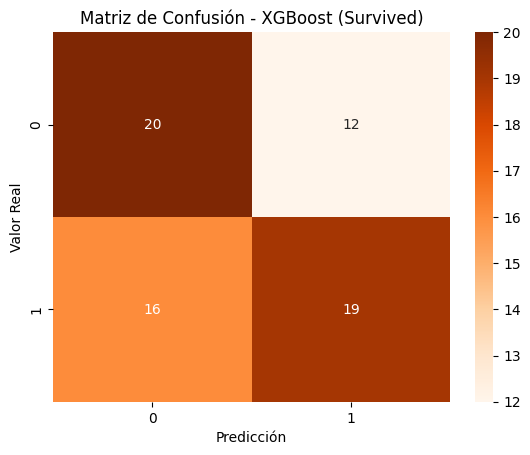

              precision    recall  f1-score   support

           0       0.56      0.62      0.59        32
           1       0.61      0.54      0.58        35

    accuracy                           0.58        67
   macro avg       0.58      0.58      0.58        67
weighted avg       0.59      0.58      0.58        67



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Matriz de confusión
matriz_surv = confusion_matrix(y_test, y_pred)
sns.heatmap(matriz_surv, annot=True, fmt='d', cmap='Oranges')
plt.title("Matriz de Confusión - XGBoost (Survived)")
plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.show()

# Reporte
print(classification_report(y_test, y_pred))

El modelo predice mejor a los perdedores con un recall de 62%, es decir, reconoce correctamente el 62% de las partidas perdidas.

Para los ganadores, el recall baja a 54%, lo que significa que el modelo detecta un poco más de la mitad de los ganadores correctamente.

La precisión es similar para ambos grupos (56% y 61%), indicando que las predicciones positivas para ambos tienen una tasa moderada de aciertos.

La exactitud global es baja (58%), mostrando que el modelo tiene un desempeño moderado, apenas mejor que el azar.

# Prediccion de Supervivencia

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

# 1. Filtrar datos válidos (si quieres, por ejemplo, partidas no anormales)
df = df[df['AbnormalMatch'] == False].copy()

# 2. Variables predictoras (puedes ajustar según tus datos)
X = df[[
    'RoundKills',
    'RoundAssists',
    'RoundHeadshots',
    'TimeAlive',
    'RLethalGrenadesThrown',
    'RNonLethalGrenadesThrown',
    'PrimarySMG',
    'PrimaryAssaultRifle',
    'PrimarySniperRifle',
    'PrimaryHeavy',
    'PrimaryPistol',
    'RoundStartingEquipmentValue',
]].copy()

# 3. Target variable
y = df['Survived'].astype(int)  # Asegurarnos que sea entero (0/1)

# 4. Verificar datos nulos y filas
print(f'Filas en X: {X.shape[0]}, filas en y: {y.shape[0]}')
print(f'¿Hay valores nulos en X?: {X.isnull().any().any()}')
print(f'¿Hay valores nulos en y?: {y.isnull().any()}')

# 5. División en train/test con estratificación para balancear clases
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 6. Entrenar el modelo XGBoost
modelo_xgb = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

modelo_xgb.fit(X_train, y_train)

# 7. Predecir y evaluar
y_pred = modelo_xgb.predict(X_test)
print(classification_report(y_test, y_pred))


Filas en X: 79157, filas en y: 79157
¿Hay valores nulos en X?: False
¿Hay valores nulos en y?: False


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:16:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.70      0.81      0.75      9443
           1       0.64      0.49      0.55      6389

    accuracy                           0.68     15832
   macro avg       0.67      0.65      0.65     15832
weighted avg       0.68      0.68      0.67     15832



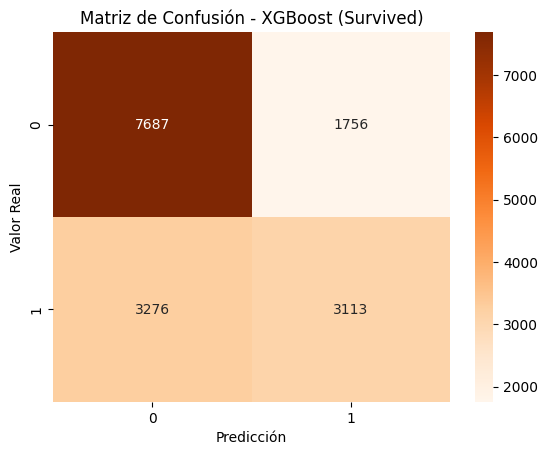

              precision    recall  f1-score   support

           0       0.70      0.81      0.75      9443
           1       0.64      0.49      0.55      6389

    accuracy                           0.68     15832
   macro avg       0.67      0.65      0.65     15832
weighted avg       0.68      0.68      0.67     15832



In [ ]:
# Matriz de confusión
matriz_surv = confusion_matrix(y_test, y_pred)
sns.heatmap(matriz_surv, annot=True, fmt='d', cmap='Oranges')
plt.title("Matriz de Confusión - XGBoost (Survived)")
plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.show()

# Reporte
print(classification_report(y_test, y_pred))

El modelo detecta mejor a los que no sobrevivieron (clase 0), con un recall alto (81%), es decir, identifica bien a la mayoría de ellos.

En cambio, para los que sí sobrevivieron (clase 1), el recall es más bajo (49%), es decir, se pierde cerca de la mitad.

La precisión para sobrevivientes es un poco más baja (64%), indica que de las predicciones positivas muchas no son correctas.

La precisión y recall más balanceados y altos para la clase 0 genera que la exactitud global sea 68%.